# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание проекта**

Компания «ГлавРосГосНефть» планирует бурение новой скважины и выбор региона для добычи. Для этого требуется построить модель, которая предскажет объём запасов нефти в новых скважинах, а также оценить возможные прибыли и риски с помощью техники Bootstrap. 


**Цель проекта**

Определить регион с наибольшей средней прибылью, обеспечивающий вероятность убытков менее 2.5%.

**Ход исследования и декомпозиция шагов**
1. [Загрузка и подготовка данных](#загрузка)
- Импорт данных из предоставленных файлов.
- Изучение структуры данных (идентификатор скважины, признаки f0, f1, f2, объём запасов product).
- Проверка данных на пропуски и дубликаты.
2. [Обучение и проверка модели для каждого региона](#обучение)
- Разделить данные на обучающую и валидационную выборки (75:25).
- Обучить модель линейной регрессии и получить предсказания на валидационной выборке.
- Сохранить предсказания и фактические значения объёмов запасов.
- Рассчитать средний предсказанный объём сырья и RMSE модели.
- Проанализировать результаты для каждого региона.
3. [Подготовка к расчёту прибыли](#подготовка)
- Сохранить ключевые значения для расчётов: бюджет, доход с единицы продукции, количество лучших скважин.
- Рассчитать минимальный объём сырья, необходимый для безубыточной разработки. Сравнить этот объём с предсказанными средними запасами.
- Сделать выводы о возможности безубыточной разработки в каждом регионе.
4. [Функция для расчёта прибыли](#функция)
- Отобрать 200 скважин с максимальными значениями предсказаний.
- Подсчитать целевое значение объёма сырья для выбранных скважин.
- Рассчитать прибыль, исходя из предсказанных объёмов сырья.
5. [Анализ рисков и прибыли](#анализ)
- Использовать технику Bootstrap для оценки распределения прибыли (1000 выборок).
- Вычислить:
  - Среднюю прибыль;
  - 95%-й доверительный интервал;
  - Вероятность убытков.
5.3. [Общий выводы:](#вывод)
- Выбрать регион с наибольшей средней прибылью и вероятностью убытков менее 2.5%.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах:
- `/datasets/geo_data_0.csv`
- `/datasets/geo_data_1.csv`
- `/datasets/geo_data_2.csv`
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

<a id='загрузка'></a>
## Загрузка и подготовка данных

**Импорт библитек:**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  на месте
</div>



**Изучение общей информации о данных**

In [2]:
# Загрузка датасетов
try:
    first_geo = pd.read_csv('/datasets/geo_data_0.csv')
    second_geo = pd.read_csv('/datasets/geo_data_1.csv')
    third_geo = pd.read_csv('/datasets/geo_data_2.csv')
except FileNotFoundError:
    first_geo = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    second_geo = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    third_geo = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [3]:
# Функция для получения общей информации о таблицах
def detailed_df_analysis(df):
    display(df.head())
    print('')
    display(df.info())
    print('')
    display(df.describe().T)
    print('')
    # Пропущенные значения
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    print("Пропущенные значения:")
    print(pd.DataFrame({'count': missing_values, 'percentage': missing_percent}), "\n")

    # Количество дубликатов строк
    duplicates = df.duplicated().sum()
    print(f"Количество дубликатов: {duplicates}\n")
    id_duplicates = df['id'].value_counts()
    #print('Кол-во неявных дубликатов в столбце id:', len(df) - id_duplicates.count())
    #print('')
    
    # Информация по категориальным столбцам
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print("Информация о категориальных признаках:")
        for col in categorical_cols:
            unique_count = df[col].nunique()
            print(f"{col} => {unique_count} уникальных значений")
        print()
        
    # Распределение вещественного числового признака 'product'
    if 'product' in df.columns:
        plt.figure(figsize=(12, 6))
        
        # Гистограмма
        plt.subplot(1, 2, 1)
        sns.histplot(df['product'], kde=True, bins=30, color='blue')
        plt.title("Распределение 'product'")
        plt.xlabel('Объём запасов (тыс. баррелей)')
        plt.ylabel('Частота')
        
        # Боксплот
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df['product'], color='cyan')
        plt.title("Боксплот 'product'")
        plt.xlabel('Объём запасов (тыс. баррелей)')
        
        plt.tight_layout()
        plt.show()

In [4]:
# функция для построения гистограммы по указанному столбцу
# принимает столбец, кол-во корзин и ограничения осей
def hist(seria, bins, xlim_max, ylim_max):
    plt.figure(figsize=[12,9])

    plt.hist(seria, bins=bins)

    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])

    plt.xlabel("Объем нефти на скважину, тыс. барелей")
    plt.ylabel("Количество скважин")

    plt.title("Гистограмма распределения по объему скважин")
    plt.show()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347



Пропущенные значения:
         count  percentage
id           0         0.0
f0           0         0.0
f1           0         0.0
f2           0         0.0
product      0         0.0 

Количество дубликатов: 0

Информация о категориальных признаках:
id => 99990 уникальных значений



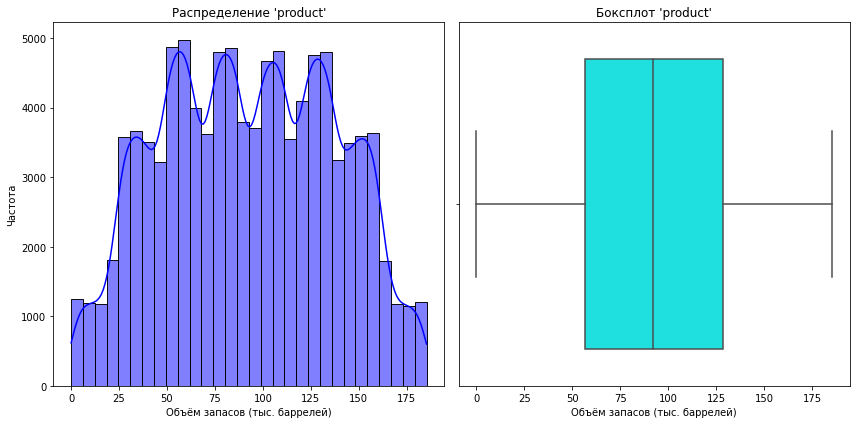

In [5]:
detailed_df_analysis(first_geo)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408



Пропущенные значения:
         count  percentage
id           0         0.0
f0           0         0.0
f1           0         0.0
f2           0         0.0
product      0         0.0 

Количество дубликатов: 0

Информация о категориальных признаках:
id => 99996 уникальных значений



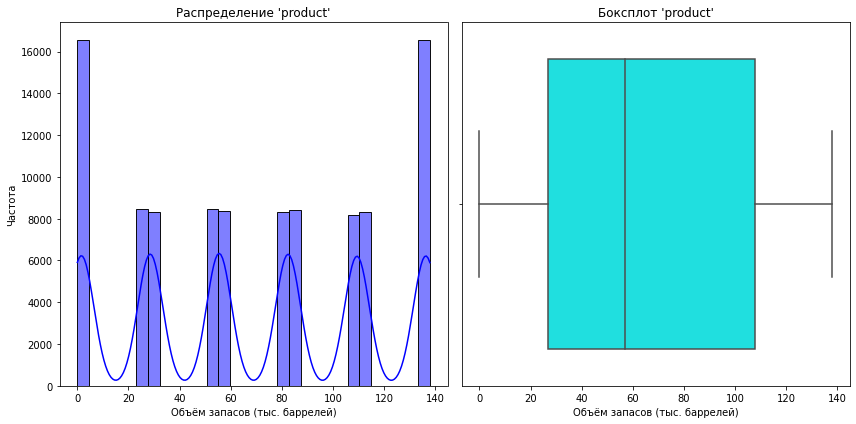

In [6]:
detailed_df_analysis(second_geo)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838



Пропущенные значения:
         count  percentage
id           0         0.0
f0           0         0.0
f1           0         0.0
f2           0         0.0
product      0         0.0 

Количество дубликатов: 0

Информация о категориальных признаках:
id => 99996 уникальных значений



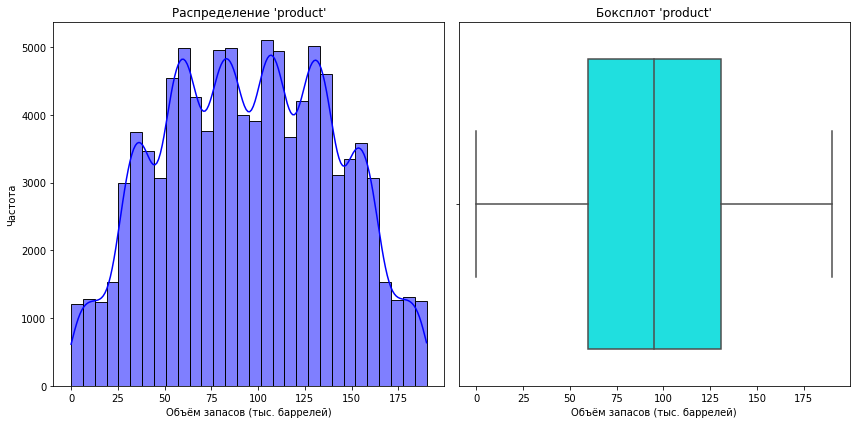

In [7]:
detailed_df_analysis(third_geo)

- Пропущенных значений не обнаружено
- Явные дубликаты не обнаружены
- Типы данных - в порядке
- Распределение целевой переменной product во втором регионе очень странное.
- Выбросов нет.

Согласно графику и информации, полученной из первичных аналитических сведений, колонка `product` заполнена непустыми значениями, скорее всего это нули. Надо это проверить и посчитать кол-во нулей.

In [9]:
# Проверим распределение product во второй таблице
# функция подсчёта нулей в значениях указанного столбца
def zeros_count(df, column):
    zeros = df[df[column] == 0][column].count()
    percent = zeros / df.shape[0]
    print('Количество нулевых значений:', zeros)
    print('Процент нулевых значений от общего числа строк:', percent)

In [10]:
zeros_count(first_geo, 'product')

Количество нулевых значений: 1
Процент нулевых значений от общего числа строк: 1e-05


In [11]:
zeros_count(second_geo, 'product')

Количество нулевых значений: 8235
Процент нулевых значений от общего числа строк: 0.08235


In [12]:
zeros_count(third_geo, 'product')

Количество нулевых значений: 1
Процент нулевых значений от общего числа строк: 1e-05


Распределение у второй таблицы выглядит исскуственным, вероятно это было сделано на намеренно.

**Подготовка данных:**

In [13]:
# Индексируем выборки
first_geo = first_geo.set_index('id')
second_geo = second_geo.set_index('id')
third_geo = third_geo.set_index('id')

In [14]:
# Избавляемся от целевого признака
features_first_geo = first_geo.drop('product', axis=1)
features_second_geo = second_geo.drop('product', axis=1)
features_third_geo = third_geo.drop('product', axis=1)

In [15]:
# Выделяем целевые признаки
target_first_geo = first_geo['product']
target_second_geo = second_geo['product']
target_third_geo = third_geo['product']

Данные в порядке и готовы к дальнейшей работе

<a id='обучение'></a>
## Обучение и проверка модели

**Обучение модели LinearRegression**

- Поскольку у нас есть три схожих датасета, разумно создать одну функцию для обучения моделей. 
- Согласно условию, для обучения подойдет только модель `LinearRegression`, так как другие методы недостаточно предсказуемы. 
- Также важно применить `стандартизацию` к *количественным параметрам* для каждой из разделенных выборок. 
- В качестве основной метрики для регрессионной модели выберем `RMSE`, так как она точнее других отражает фактическое отклонение от реальных значений.

In [16]:
def ml_regression(features, target, region):
    
    # Разбивка данных на тренировочную и валидационную
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, 
    target,
    random_state=12345,
    test_size=0.25
    )
    
    # Стандартизация для числовых признаков
    scaler = StandardScaler()
    numeric = ['f0', 'f1', 'f2']
    features_train[numeric] = scaler.fit_transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    # Инизиализация и обучение модели
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    # Предсказание
    predicted = model.predict(features_valid)
    
    print(f'Средний запас сырья в {region}:', predicted.mean())
    print('RMSE модели:', mean_squared_error(target_valid, predicted, squared=False))
    print('------')
    
    df = pd.DataFrame([], columns=['correct', 'predicted'])
    df['correct'] = target_valid
    df['predicted'] = predicted
    
    return pd.Series(predicted), pd.Series(target_valid), df

In [17]:
# Обучаем модели и сохраняем результаты
predicted_first_geo, correct_first_geo, df_first_geo = ml_regression(features_first_geo, target_first_geo, 'first_region')
predicted_second_geo, correct_second_geo, df_second_geo = ml_regression(features_second_geo, target_second_geo, 'second_region')
predicted_third_geo, correct_third_geo, df_third_geo = ml_regression(features_third_geo, target_third_geo, 'third_region')

# Сохраняем индексацию предсказанных и реальных значений
predicted_first_geo.index = correct_first_geo.index
predicted_second_geo.index = correct_second_geo.index
predicted_third_geo.index = correct_third_geo.index

Средний запас сырья в first_region: 92.59256778438035
RMSE модели: 37.5794217150813
------
Средний запас сырья в second_region: 68.728546895446
RMSE модели: 0.893099286775617
------
Средний запас сырья в third_region: 94.96504596800489
RMSE модели: 40.02970873393434
------


In [18]:
display(predicted_first_geo.shape)
display(correct_first_geo.shape)
display(df_first_geo.head())

(25000,)

(25000,)

,correct,predicted
id,,
7Z2gx,10.038645,95.894952
b2HU8,114.551489,77.572583
Y0dXD,132.603635,77.892640
Mje59,169.072125,90.175134
yqXxU,122.325180,70.510088


In [19]:
# для оценки общего запаса скважин в рамках региона, суммируем значения в рассчитанных датафреймах
print('Суммарный предсказанный запас в регионе 0 -', predicted_first_geo.sum())
print('Суммарный реальный запас в регионе 0 -', correct_first_geo.sum())
print()
print('Суммарный предсказанный запас в регионе 1 -', predicted_second_geo.sum())
print('Суммарный реальный запас в регионе 1 -', predicted_second_geo.sum())
print()
print('Суммарный предсказанный запас в регионе 2 -', predicted_third_geo.sum())
print('Суммарный реальный запас в регионе 2 -', predicted_third_geo.sum())

Суммарный предсказанный запас в регионе 0 - 2314814.194609509
Суммарный реальный запас в регионе 0 - 2301964.918520732

Суммарный предсказанный запас в регионе 1 - 1718213.67238615
Суммарный реальный запас в регионе 1 - 1718213.67238615

Суммарный предсказанный запас в регионе 2 - 2374126.1492001223
Суммарный реальный запас в регионе 2 - 2374126.1492001223


**Выводы по обучению модели:**

- Суммарные значения предсказанных объёмов примерно совпадают с суммарными фактическими результатами измерений.
- Лучше всех себя показала модель в предсказаниях на втором регионе: `RMSE = 0.893099286775617`. Скорее всего, утеряные данные из второго фрейма сказались на обучении модели, и она достаточно сильно переобучилась. Но из-за неполноты данных и в среднем малого запаса ресурсов (69.18) не имеет смысла рассматривать второй регион как прибыльное месторождение.
- Самое крупное значение среднего запаса сырья, однако же - в третьем регионе: `94.9650459680048`

<a id='подготовка'></a>
## Подготовка к расчёту прибыли

In [20]:
# Константы для основных значений
# бюджет 10 млрд. рублей
budget = 10 ** 10 
# исследуем 500 точек
chosen_points = 500 
# с помощью модели отбираем 200 лучших
best_points = 200
# доход за 1000 баррель, за один баррель - 450
income_per_barrel = 450000

In [21]:
average_profit_per_point = budget / best_points
print('Необходимая средняя прибыль на лучшую точку -', average_profit_per_point / 1000, 'тыс.руб.')

average_barrels_per_point = average_profit_per_point  / income_per_barrel
print('Необходимый средний объем нефти на точку -',average_barrels_per_point, 'тыс. баррелей')

average_barrels = budget / income_per_barrel
print('Необходимый средний объем нефти на регион -',average_barrels, 'тыс. баррелей')

Необходимая средняя прибыль на лучшую точку - 50000.0 тыс.руб.
Необходимый средний объем нефти на точку - 111.11111111111111 тыс. баррелей
Необходимый средний объем нефти на регион - 22222.222222222223 тыс. баррелей


На текущий момент, самое высокое предсказанное значение среднего запаса сырья (в третьем регионе) составляет 95.2235090834128, что недостаточно для обеспечения безубыточности производства. Аналогично, средний запас сырья в первом и втором регионах не достигает рассчитанного безубыточного уровня. Но посмотрим на распределения.

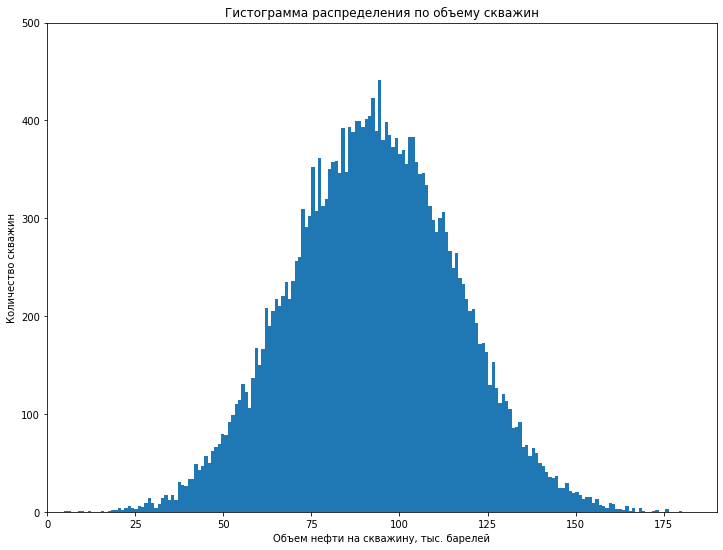

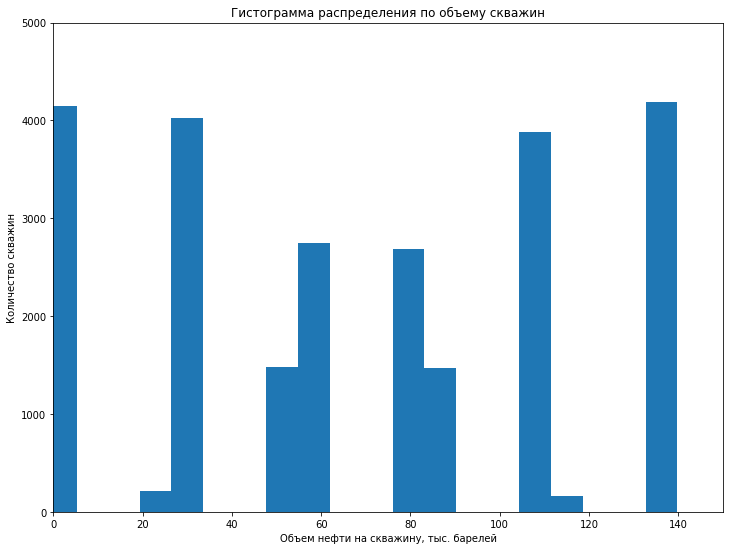

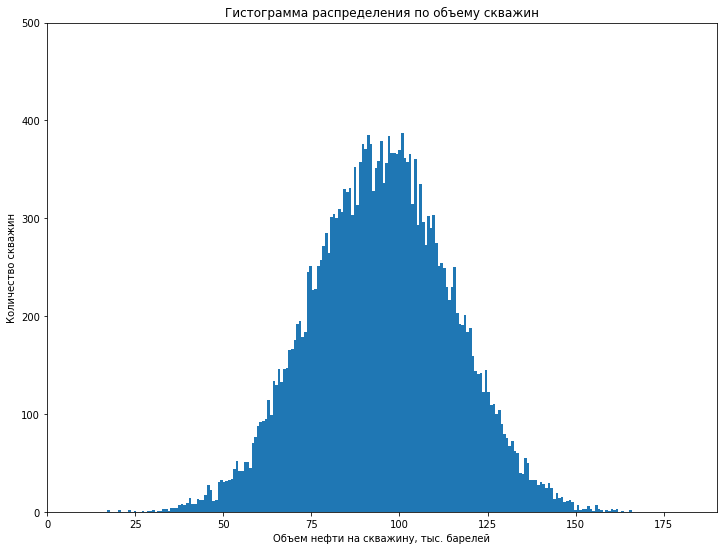

In [22]:
# проверим распределение предсказанных значений запасов по скважинам
# оцениваем гистограммы с точки зрения расчитанных выше необходимых объёмов нефти
hist(df_first_geo['predicted'], 200, 190, 500)
hist(df_second_geo['predicted'], 20, 150, 5000)
hist(df_third_geo['predicted'], 200, 190, 500)

Для первого и третьего - высокая вероятность окупить затраты. Разброс значений вокруг среднего 92.6 и 95 говорит нам о том, что существует достаточно много скважин, где запасы больше необходимого среднего - 111.

## Расчёт прибыли и рисков 

<a id='функция'></a>
### Функция для расчёта прибыли

In [23]:
# Функция для расчета прибыли на 500 разведанных точек
def revenue_count(target, probabilities_sample, count):
    probs_sorted = probabilities_sample.sort_values(ascending=False)
    # выбираем из отсортированных точек кол-во, соответствующее заданию
    selected = target[probs_sorted.index][:count]
    return income_per_barrel * selected.sum() - budget

In [24]:
state = np.random.RandomState(12345)
# # функция для применения техники Bootstrap с 1000 выборок
def bootstrap(target, probabilities):
    values = []
    lost = 0 
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=chosen_points)
        probs_sample = probabilities[target_sample.index]
        profit = revenue_count(target, probs_sample, best_points)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

<a id='анализ'></a>
### Анализ рисков и прибыли

In [25]:
average_1, lower_1, upper_1, risk_1 = bootstrap(df_first_geo['correct'], df_first_geo['predicted'])
print('Данные по первому региону.')
print('Средняя прибыль для региона = {:.2f} тыс.руб.'.format(average_1/1000))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Данные по первому региону.
Средняя прибыль для региона = 396164.98 тыс.руб.
95% доверительный интервал от -111215545.89 до 909766941.55 тыс.руб.
Процент риска 6.90%


In [26]:
average_2, lower_2, upper_2, risk_2 = bootstrap(df_second_geo['correct'], 
                                                     df_second_geo['predicted'])
print('Данные по второму региону.')
print('Средняя прибыль для региона = {:.2f} тыс.руб.'.format(average_2/1000))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_2, upper_2))
print('Процент риска {:.2%}'.format(risk_2))

Данные по второму региону.
Средняя прибыль для региона = 461155.82 тыс.руб.
95% доверительный интервал от 78050810.75 до 862952060.26 тыс.руб.
Процент риска 0.70%


In [27]:
average_3, lower_3, upper_3, risk_3 = bootstrap(df_third_geo['correct'], 
                                                     df_third_geo['predicted'])
print('Данные по второму региону.')
print('Средняя прибыль для региона = {:.2f} тыс.руб.'.format(average_3/1000))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_3, upper_3))
print('Процент риска {:.2%}'.format(risk_3))

Данные по второму региону.
Средняя прибыль для региона = 392950.48 тыс.руб.
95% доверительный интервал от -112227625.38 до 934562914.55 тыс.руб.
Процент риска 6.50%


Мы отсеиваем первый и третий регион, так как риски относительно велики (6.9% и 6.5%).
Остается один единственный регион - второй. Его риск ниже требуемого (0.7%). Кроме того 95% доверительный интервал показывает, что даже при не слишком удачном выборе скважин разработка окупится.

<a id='вывод'></a>
## Общий вывод

**Загрузка и подготовка данных:**

- Импортировали нужные библиотеки и загрузили 3 датасэта: `first_geo`, `second_geo` и `third_geo`
- Написали функцию `detailed_df_analysis` для получения общей информации о данных.
- Определили, что данные в порядке и готовы к дальнейшей работе:
  - Пропущенные значения и явные дубликаты в данных не были обнаружены.
  - Типы данных - тоже в порядке.
  - Аномальных значений нет.

**Подготовка данных для обучение модели:**

- Проиндексировали выборки по id.
- Выделили нецелевые и целевой признаки в данных.

**Обучение и проверка модели**

- Написали функцию для обучения модели *LinearRegression*, которая:
  - разделяет загруженный набор данных на обучающую и валидационные выборки в соотношении 75:25;
  - применяет стандартизацию для всех выборок по количественным признакам;
  - обучает модель линейной регрессии;
  - записывает предсказания модели;
  - выводит на экран средний запас сырья в определенном регионе и среднюю квадратичную ошибку (RMSE) модели;
- Лучше всех себя показала модель в предсказаниях на втором регионе: `RMSE - 0.893099286775617`.
- Самое крупное значение среднего запаса сырья - в третьем регионе: `94.96504596800489`.

**Подготовка к расчету прибыли**

- Задали основные константы для выполнения условий исследования.
- Рассчитали ключевые показатели для оценки прибыльности региона:
  - Требуемая средняя прибыль на одну скважину: `50,000.0 тыс. руб`.
  - Необходимый средний объем нефти на одну скважину для безубыточности: `111.11 тыс. баррелей`.
  - Необходимый средний объем нефти на регион: `22,222.22 тыс. баррелей`.
  
**Расчет прибыли и рисков**

- Создали функцию *revenue_count* для подсчета прибыли
- Применили метод *Bootstrap*: 1000 раз создали выборки из 500 скважин и посчитали необходимые метрики.
- Вычислили прибыль и риски для каждого региона, что позволило обосновать выбор наиболее подходящего региона. Второй регион показал один из лучших результатов по предсказаниям, однако распределение данных отличается от нормального, что вызывает сомнения в точности полученных результатов:
  - Средняя прибыль для региона: `461,155.82 тыс. руб`.
  - 95% доверительный интервал: от `78,050,810.75 до 862,952,060.26 тыс. руб`.
  - `Риск убытков: 0.7%`.